In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import gradio as gr

c:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load CSV file
df = pd.read_csv(r"C:\Users\Dell\Downloads\spam.csv")
# Show first 5 rows
print(df)

     Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [4]:

# Pipeline-friendly preprocessor
def simple_preprocessor(text):      # text cleaning function
    if not isinstance(text, str):   #ensure input is string
        text = str(text)            # convert to string if not
    text = text.lower()             # convert to lowercase
    text = re.sub(r"http\S+|www\.\S+", "", text)   # remove URLs
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    return text


In [5]:
# Features and labels
X = df["Message"]       # text data
y = df["Category"]      # labels (ham/spam)

# TF-IDF with preprocessing + stopword removal
tfidf = TfidfVectorizer(
    preprocessor=simple_preprocessor,
    stop_words="english"
)

X_tfidf = tfidf.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)



TF-IDF shape: (5572, 9209)


              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.94      0.89      0.91       149

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



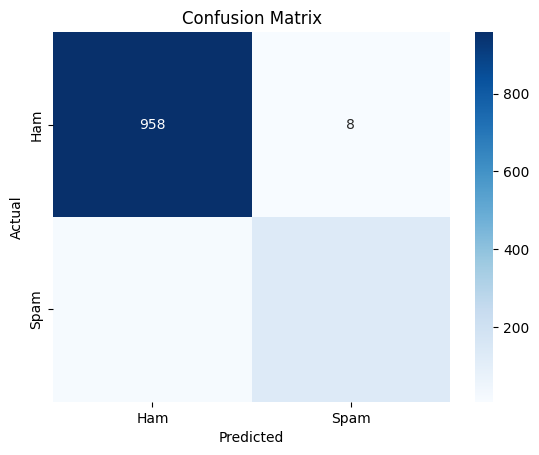

In [6]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


# Logistic Regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"], 
            yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [7]:
# Save the trained model
joblib.dump(model, "spam_model.pkl")

# Save the trained TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [8]:

# Load saved objects
model = joblib.load("spam_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

def predict_message(msg):  #prediction function
    if not msg.strip():
        return "Please enter a message", 0.0
    
    # Vectorize input (must be list, not string)
    X_vec = vectorizer.transform([msg])
    
    # Predict
    pred = model.predict(X_vec)[0]
    prob = model.predict_proba(X_vec)[0][list(model.classes_).index("spam")]
    
    return pred, float(prob)

# Gradio interface
demo = gr.Interface(
    fn=predict_message,
    inputs=gr.Textbox(lines=3, placeholder="Enter SMS message..."),
    outputs=[
        gr.Textbox(label="Prediction (ham/spam)"),
        gr.Number(label="Spam Probability")
    ],
    title="📩 SMS Spam Detector"
)

demo.launch(share=False)  # set share=True if you want a public link


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
